In [2]:
import chess.pgn  # (Portable Game Notation)
import pandas as pd
from tqdm import tqdm  # For a progress bar, useful in case of large files
import csv
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch

In [26]:
# 1) and 2)
# Start by activating the virtual environment: source chess-nlp-env/bin/activate

pgn_path = "../data/processed/lichess_db_standard_rated_2014-09.pgn"
output_csv = "../data/processed/chess_games.csv"

num_games = 500  # First 5000 games from the dataset
min_plies_required = 6

with open(output_csv, "w", newline="", encoding="utf-8") as fout:  # write mode ('w') with newline='' to prevent extra blank rows.
    writer = csv.writer(fout)  # writer object is responsible for handling the CSV formatting.
    writer.writerow(["white", "white_elo", "black", "black_elo", "result", "date", "moves"])

    with open(pgn_path, encoding="utf-8") as pgn_file:  # with block ensures the file is automatically closed when done (or on error)
        for _ in tqdm(range(num_games)):
            game = chess.pgn.read_game(pgn_file)  # reads the next PGN entry from the open file and returns a Game object
            if game is None:
                break  # end of file
    
            # 'read_game' reads whole PGN blocks (headers + move text)
            try:
                # All the features in the data
                # game.headers: a dict-like mapping of PGN tag names to values
                # .get(key, default): returns value if present, else default '?' prevents KeyError and preserves placeholder if metadata missing.
                white = game.headers.get("White", "?")
                white_elo = game.headers.get("WhiteElo", "?")
                black = game.headers.get("Black", "?")
                black_elo = game.headers.get("BlackElo", "?")
                result = game.headers.get("Result", "?")
                date = game.headers.get("Date", "?")
    
                board = game.board()  # An actual chess board
                moves = []
                for move in game.mainline_moves():  # Gives a move object
                    try:
                        san = board.san(move)  # board.san(move): Python-Chess verifies that the move is legal from the current position.
                        moves.append(san)
                        board.push(move)  # updates board state
                    except Exception:
                        # Skip illegal move: illegal move raises an Assertion error
                        moves = []
                        break
    
                if not moves or len(moves) < min_plies_required:
                    continue  # skip this game and minimum number of plies/tokens for a checkmate is 6: The fool's mate
    
                writer.writerow([white, white_elo, black, black_elo, result, date, " ".join(moves)])  # Instead of storing game as a list, saving memory
                                                                                      # and writing directly to csv

            except Exception as e:
                # Skip the whole game if anything else fails
                continue

print(f"\nFinished processing {num_games} games.")
print(f"Clean data written to: {output_csv}")

data = pd.read_csv(output_csv)
print(f"Number of valid games: {len(data)}.\n")
print(data.head())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 369.03it/s]


Finished processing 500 games.
Clean data written to: ../data/processed/chess_games.csv
Number of valid games: 496.

         white  white_elo       black  black_elo result        date  \
0       KACHAL       1833  justplaybi       1823    0-1  ????.??.??   
1     mustroll       1600       pelao       1658    1-0  ????.??.??   
2  luciano2000       1754     amnezia       1790    1-0  ????.??.??   
3      martinz       1601       HighP       1650    1-0  ????.??.??   
4      Thoth33       1657  JaiSkiesNY       1545    1-0  ????.??.??   

                                               moves  
0  e4 d5 Nf3 dxe4 Ne5 Nf6 d4 exd3 Bxd3 e6 Nc3 Bd6...  
1  b4 e5 Bb2 d6 c3 Bf5 d3 Nf6 e4 Bg6 Be2 Be7 Nf3 ...  
2  e4 d5 exd5 Qxd5 Nc3 Qa5 Nf3 Nf6 d4 Bg4 Bd2 Nc6...  
3  e4 e5 Nf3 Nf6 Nc3 d6 Bc4 Be6 Qe2 Nbd7 d4 Bxc4 ...  
4  d4 e6 c4 c6 Nc3 d5 cxd5 cxd5 e4 Nc6 e5 Qb6 Nge...  


In [27]:
data.info()
print("\n---\n")  # separator

print("Data shape:", data.shape, "\n")

# This splits each move by " " and creates a list of all moves in a column, then calculates their length and then this new Series
# that contains lengths of moves in a game is used for getting Statistical Summary of the number of moves in each game
print(data['moves'].apply(lambda s: len(s.split())).describe(), "\n")  # Analyzes the distribution of move lengths

# Adding the num_moves column that will have number of moves in each game
data["moves_list"] = data["moves"].apply(lambda x: x.split(" "))
data["num_moves"] = data["moves_list"].apply(len)

print(data['result'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   white      496 non-null    object
 1   white_elo  496 non-null    int64 
 2   black      496 non-null    object
 3   black_elo  496 non-null    int64 
 4   result     496 non-null    object
 5   date       496 non-null    object
 6   moves      496 non-null    object
dtypes: int64(2), object(5)
memory usage: 27.2+ KB

---

Data shape: (496, 7) 

count    496.000000
mean      68.574597
std       29.362494
min        6.000000
25%       48.750000
50%       66.500000
75%       85.000000
max      187.000000
Name: moves, dtype: float64 

result
1-0        247
0-1        229
1/2-1/2     20
Name: count, dtype: int64


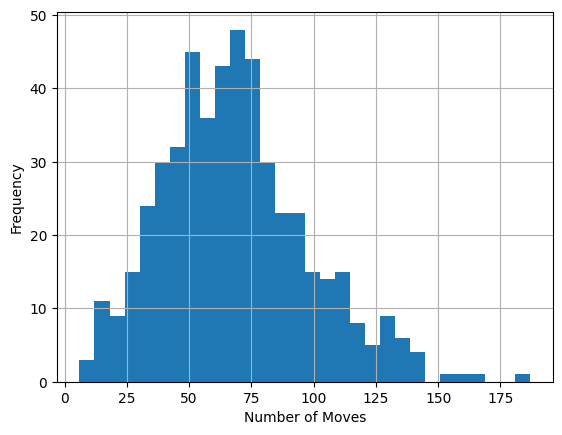

In [28]:
# Histogram of game lengths

data['num_moves'].hist(bins = 30)
plt.xlabel("Number of Moves")
plt.ylabel("Frequency")
plt.show()

In [30]:
# 3) and 4)

# Building a vocab dictionary

# each row is a list in data['moves_list']
# .explode() expands it so that each list element becomes a separate row and .unique() extracts distinct SAN strings
unique_moves = data['moves_list'].explode().unique()
print(unique_moves[:20])

vocab = {move: idx for idx, move in enumerate(unique_moves, start = 2)}
cnt = 0
print("\nVocab")
for move, idx in vocab.items():
    if cnt < 20:
        print(move, ": ", idx)
        cnt += 1
    else:
        break

vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

inv_vocab = {id: mv for mv, id in vocab.items()}  # Inverse vocab for decoding
cnt = 0
print("\nInverse vocab")
for idx, move in inv_vocab.items():
    if cnt < 20:
        print(idx, ": ", move)
        cnt += 1
    else:
        break

# Now, converting every game’s move list to integer IDs
data["encoded_moves"] = data['moves_list'].apply(lambda moves: [vocab[m] for m in moves])

print("\nEncoded moves list")
data["encoded_moves"].head()

['e4' 'd5' 'Nf3' 'dxe4' 'Ne5' 'Nf6' 'd4' 'exd3' 'Bxd3' 'e6' 'Nc3' 'Bd6'
 'Nc4' 'Nc6' 'Bg5' 'Be7' 'Qd2' 'Nb4' 'O-O-O' 'Nxd3+']

Vocab
e4 :  2
d5 :  3
Nf3 :  4
dxe4 :  5
Ne5 :  6
Nf6 :  7
d4 :  8
exd3 :  9
Bxd3 :  10
e6 :  11
Nc3 :  12
Bd6 :  13
Nc4 :  14
Nc6 :  15
Bg5 :  16
Be7 :  17
Qd2 :  18
Nb4 :  19
O-O-O :  20
Nxd3+ :  21

Inverse vocab
2 :  e4
3 :  d5
4 :  Nf3
5 :  dxe4
6 :  Ne5
7 :  Nf6
8 :  d4
9 :  exd3
10 :  Bxd3
11 :  e6
12 :  Nc3
13 :  Bd6
14 :  Nc4
15 :  Nc6
16 :  Bg5
17 :  Be7
18 :  Qd2
19 :  Nb4
20 :  O-O-O
21 :  Nxd3+

Encoded moves list


0    [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...
1    [60, 61, 62, 63, 64, 45, 65, 7, 2, 66, 67, 17,...
2    [2, 3, 35, 150, 12, 151, 4, 7, 8, 152, 153, 15...
3    [2, 61, 4, 7, 12, 63, 194, 37, 195, 196, 8, 89...
4    [8, 11, 83, 26, 12, 3, 214, 214, 2, 15, 61, 21...
Name: encoded_moves, dtype: object

In [31]:
# 5) 
# Creating Input_sequence and Target pairs (X, y)

X = []
y = []

for moves in data["moves_list"]:
    for i in range (1, len(moves)):
        seq_input = moves[:i]  # All moves till i
        seq_output = moves[i]  # Next move
        X.append(seq_input)
        y.append(seq_output)


# Converting input and target to IDs 

PAD = vocab['<PAD>']
UNK = vocab['<UNK>']

X_ids = []
y_ids = []

for seq_input, seq_output in zip(X, y):
    input_ids = [vocab.get(m, UNK) for m in seq_input]  # Unknown moves (not in vocab) are replaced with <UNK> 
    output_ids = vocab.get(seq_output, UNK)

    X_ids.append(input_ids)
    y_ids.append(output_ids)

y_ids[100:110]

[81, 82, 83, 37, 84, 85, 86, 87, 88, 89]

In [32]:
# 6)
# Converting X_ids and y_ids to tensors and padding the sequences in X_ids to bring them to equal length sequences

X_tensor = [torch.tensor(seq) for seq in X_ids]  # 2D tensor of size: N x max_move_sequence_length (list of tensors)
y_tensor = torch.tensor(y_ids)  # 1D tensor

X_padded = pad_sequence(X_tensor, batch_first = True, padding_value = PAD)  # batch_first = True: number of samples

In [ ]:
# Converting moves to tokens and building vocabulary where vocab = {move: idx} where idx starts at 4 (reserve 0 PAD, 1 UNK, 2 BOS, 3 EOS)
# Saving vocabulary in vocab.json and inv_vocab for decoding

In [ ]:
# Next steps
'''
Build a vocabulary from the moves column: move -> id.

Convert sequences into integer token lists and save as .npy or PyTorch tensors.

Create a Dataset class yielding (input_seq, next_move) pairs for training.

Implement and train LSTM baseline; then implement Transformer from scratch.
'''